In [1]:
%pylab inline
import pandas as pd
import dask.dataframe as dd
import os,sys
import logging
import fastparquet
import gc
import cPickle as pickle 

Populating the interactive namespace from numpy and matplotlib


In [2]:
!head ../input/third2/HPI_PO_us_and_census.txt

In [3]:
def read_po_quater_hpi():
    df=pd.read_csv("../input/third2/HPI_PO_us_and_census.txt" ,sep="\t")
    df['hpi']=df['index_po_not_seasonally_adjusted'].astype(np.float)
    df=df[df.year>2005]
    df['division']=df['division'].map(lambda u: u.split("_")[-1])
    df=df[df['division'].isin({"MA",'ENC','WNC','SA','PAC','USA'})]
    df['Month']=pd.to_datetime(df.apply(lambda u: '{}-{}-{}'.format(u['year'], (u['qtr']-1)*3+2,1),axis=1))
    df=df.drop(['index_po_not_seasonally_adjusted','index_po_seasonally_adjusted'],axis=1)
    df=pd.pivot_table(df,index='Month', columns='division',values='hpi')
    df=df[["MA",'ENC','WNC','SA','PAC']]
    assert df.isnull().sum().sum()==0
    return df

In [9]:
quater_hpi=read_po_quater_hpi()
quater_hpi=quater_hpi/quater_hpi.iloc[0]

In [10]:
quater_hpi.head()

division          MA       ENC       WNC        SA       PAC
Month                                                       
2006-02-01  1.000000  1.000000  1.000000  1.000000  1.000000
2006-05-01  1.018414  1.019451  1.017782  1.019760  1.015755
2006-08-01  1.021118  1.017930  1.023869  1.025431  1.009582
2006-11-01  1.016130  1.002674  1.013612  1.030027  0.989700
2007-02-01  1.015197  0.998637  1.018405  1.030929  0.989449

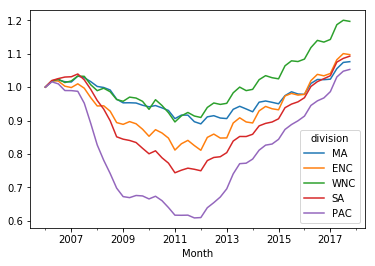

In [11]:
(quater_hpi/quater_hpi.iloc[0]).plot()

In [20]:
def read_po_state_hpi():
    df=pd.read_csv("../input/third2/HPI_PO_state.txt" ,sep="\t")
    df=df[df['state'].isin({'IA','CA','NY','NC','OH'})]
    df['hpi']=df['index_nsa'].astype(np.float)
    df=df[df.yr>2005]
    df['Month']=pd.to_datetime(df.apply(lambda u: '{}-{}-{}'.format(u['yr'], (u['qtr']-1)*3+2,1),axis=1))
    df=df.drop(['index_nsa','index_sa','Warning'],axis=1)
    assert df.isnull().sum().sum()==0
    df=pd.pivot_table(df, columns='state',values='hpi', index=['Month'])
    df=df[["NY", "OH", "IA", "NC", "CA"]]
    return df

In [25]:
state_hpi=read_po_state_hpi()
state_hpi=state_hpi/state_hpi.iloc[0]

In [26]:
state_hpi.head()

state             NY        OH        IA        NC        CA
Month                                                       
2006-02-01  1.000000  1.000000  1.000000  1.000000  1.000000
2006-05-01  1.016378  1.020146  1.020193  1.020310  1.005911
2006-08-01  1.013493  1.015267  1.027097  1.037887  0.988703
2006-11-01  1.011400  0.998680  1.019155  1.054927  0.959639
2007-02-01  1.003862  0.991161  1.023048  1.065377  0.950930

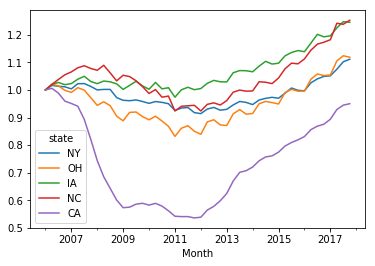

In [27]:
(state_hpi/state_hpi.iloc[0]).plot()

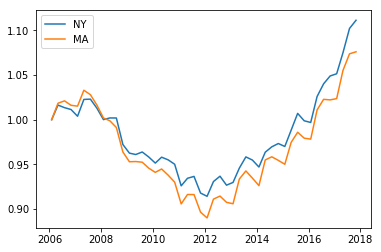

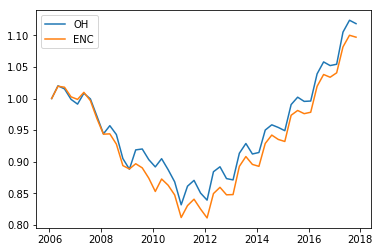

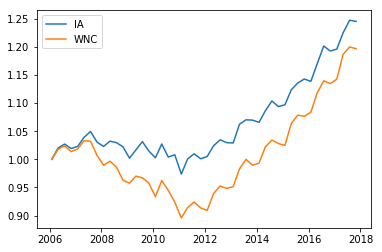

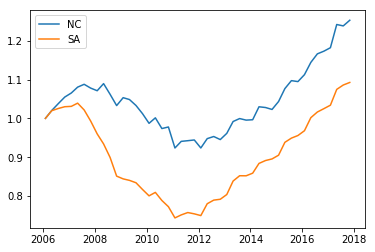

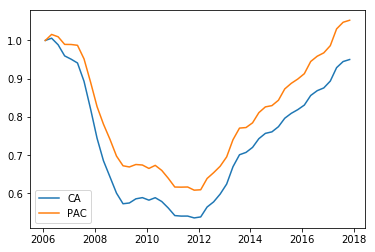

In [29]:
for i in range(state_hpi.shape[1]):
    plt.plot(state_hpi.iloc[:,i])
    plt.plot(quater_hpi.iloc[:,i])
    plt.legend([state_hpi.columns[i],quater_hpi.columns[i]])
    plt.show()

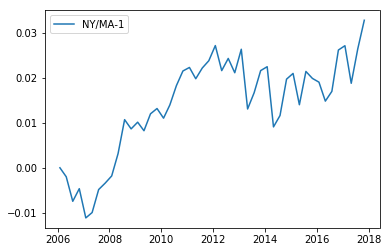

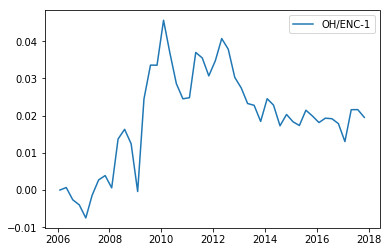

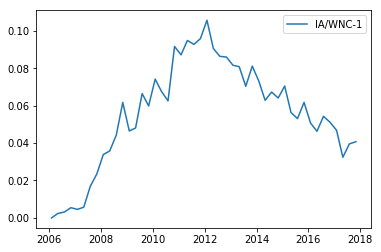

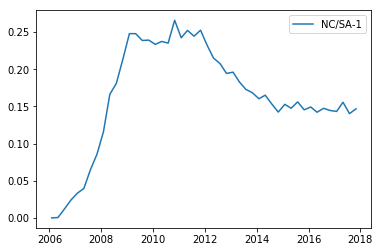

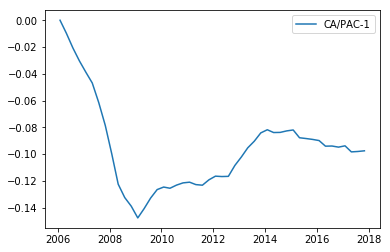

In [31]:
for i in range(state_hpi.shape[1]):
    plt.plot(state_hpi.iloc[:,i]/quater_hpi.iloc[:,i]-1)
    plt.legend(['{}/{}-1'.format(state_hpi.columns[i],quater_hpi.columns[i])])
    plt.show()

In [44]:
pd.concat([a,b],1)

NY        OH        IA        NC        CA        MA  \
Month                                                                    
2006-02-01       NaN       NaN       NaN       NaN       NaN       NaN   
2006-05-01  1.016378  1.020146  1.020193  1.020310  1.005911  1.018414   
2006-08-01  0.997162  0.995218  1.006767  1.017227  0.982894  1.002655   
2006-11-01  0.997934  0.983662  0.992267  1.016419  0.970604  0.995115   
2007-02-01  0.992547  0.992471  1.003820  1.009906  0.990925  0.999082   
2007-05-01  1.018772  1.017372  1.015476  1.014134  0.989665  1.017541   
2007-08-01  1.000318  0.991064  1.010293  1.006795  0.949086  0.995171   
2007-11-01  0.990040  0.972663  0.981898  0.990985  0.919375  0.988618   
2008-02-01  0.987413  0.971245  0.992495  0.993736  0.906257  0.985826   
2008-05-01  1.001861  1.013679  1.009237  1.017059  0.921092  0.996883   
2008-08-01  0.999954  0.985366  0.997385  0.974718  0.938313  0.992485   
2008-11-01  0.970325  0.959586  0.992790  0.972700  0.933986  0.972301   
2009-02-01  0.990093  0.981479  0.980245  1.019714  0.953889  0.988634   
2009-05-01  0.998356  1.034380  1.014610  0.995421  1.003479  1.000245   
2009-08-01  1.002954  1.001562  1.014553  0.985383  1.018916  0.999217   
2009-11-01  0.994159  0.981661  0.983744  0.979616  1.005313  0.993000   
2010-02-01  0.992910  0.987291  0.988182  0.975433  0.988837  0.995021   
2010-05-01  1.006945  1.014546  1.024541  1.014330  1.011049  1.004013   
2010-08-01  0.996892  0.980778  0.977361  0.972441  0.983014  0.992697   
2010-11-01  0.994836  0.978331  1.004033  1.004127  0.970636  0.991649   
2011-02-01  0.974534  0.958083  0.965961  0.944648  0.964830  0.973784   
2011-05-01  1.009146  1.035401  1.027562  1.018507  0.997484  1.011633   
2011-08-01  1.002241  1.010730  1.009183  1.001823  1.000129  0.999898   
2011-11-01  0.980076  0.976921  0.991261  1.001990  0.991075  0.978525   
2012-02-01  0.996046  0.986838  1.004149  0.978154  1.004829  0.992771   
2012-05-01  1.018069  1.053557  1.018903  1.026047  1.047990  1.023625   
2012-08-01  1.006449  1.008894  1.010341  1.005767  1.023919  1.003787   
2012-11-01  0.989270  0.979022  0.995184  0.991736  1.035161  0.992353   
2013-02-01  1.003314  0.997634  0.999345  1.016948  1.043964  0.998202   
2013-05-01  1.017266  1.048425  1.032387  1.031715  1.072465  1.030623   
2013-08-01  1.013283  1.016904  1.007476  1.007672  1.046838  1.009688   
2013-11-01  0.996310  0.982141  0.999466  0.995979  1.008729  0.991493   
2014-02-01  0.991813  1.002580  0.996360  1.000969  1.018543  0.990971   
2014-05-01  1.017541  1.038848  1.019287  1.033504  1.031605  1.031058   
2014-08-01  1.006229  1.008760  1.016007  0.998179  1.018683  1.003710   
2014-11-01  1.003839  0.995628  0.991064  0.995152  1.005220  0.995866   
2015-02-01  0.996606  0.994647  1.002752  1.019958  1.017740  0.995360   
2015-05-01  1.018756  1.043541  1.024372  1.031894  1.028539  1.025762   
2015-08-01  1.019117  1.011822  1.010810  1.019062  1.016113  1.011720   
2015-11-01  0.991776  0.993356  1.006261  0.997753  1.011925  0.993286   
2016-02-01  0.998090  1.000577  0.996276  1.016300  1.014560  0.998905   
2016-05-01  1.029172  1.043160  1.027536  1.028417  1.030218  1.033454   
2016-08-01  1.013878  1.018229  1.027020  1.019202  1.014706  1.011713   
2016-11-01  1.008454  0.994521  0.992526  1.005928  1.008173  0.999407   
2017-02-01  1.002351  1.002018  1.002916  1.007629  1.020526  1.001414   
2017-05-01  1.022436  1.048233  1.024217  1.050549  1.039286  1.030832   
2017-08-01  1.025276  1.017035  1.018263  0.997109  1.017169  1.017628   
2017-11-01  1.008358  0.995200  0.998335  1.011772  1.005589  1.002127   

                 ENC       WNC        SA       PAC  
Month                                               
2006-02-01       NaN       NaN       NaN       NaN  
2006-05-01  1.019451  1.017782  1.019760  1.015755  
2006-08-01  0.998509  1.005981  1.005560  0.993923  
2006-11-01  0.985012  0.989982  1.004482  0.980307  

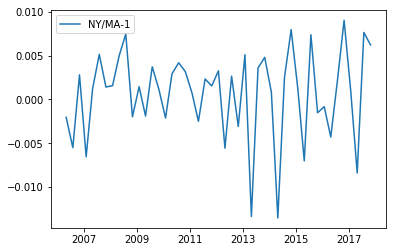

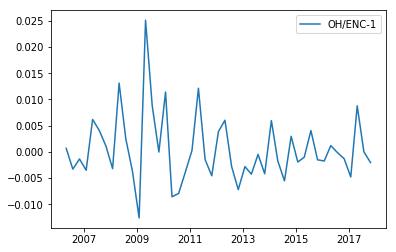

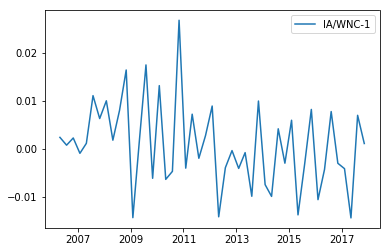

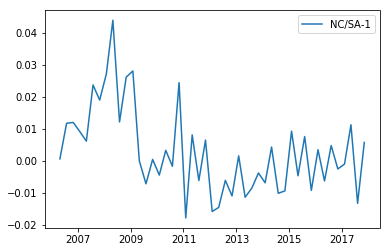

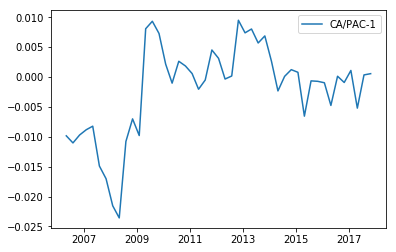

In [45]:
a=np.exp(np.log(state_hpi).diff(axis=0))
b=np.exp(np.log(quater_hpi).diff(axis=0))
for i in range(state_hpi.shape[1]):
    #print a.iloc[:,i], b.iloc[:,i]
    plt.plot(a.iloc[:,i]-b.iloc[:,i])
    plt.legend(['{}/{}-1'.format(a.columns[i],b.columns[i])])
    plt.show()